# Installation

In [1]:
# !conda install -c conda-forge cvxpy

cvxpy homepage: https://www.cvxpy.org/index.html \
example source: https://www.cvxpy.org/examples/index.html# \
cvxpy github: https://github.com/cvxpy/cvxpy \
matlab cvx homepage: http://cvxr.com/cvx/

Solver

Open Source:
- CLARABEL: Rust library for solving convex cone programs.  Ref: https://oxfordcontrol.github.io/ClarabelDocs/stable/
- ECOS: Embedded Conic Solver Ref: https://github.com/embotech/ecos
- ECOS_BB: Mixed-Integer SOCPs(second-order cone programs)
- SCS: splitting conic solver Ref: https://www.cvxgrp.org/scs/
- OSQP: Operator Splitting Quadratic Program Ref: https://osqp.org/ (oxford)
- CVXOPT: convex optimization based on the Python Ref: https://cvxopt.org/

- SCIP: Solving Constraint Integer Programs: Ref: https://scipopt.org/ 

Commercial:
- GUROBI
- MOSEK
- XPRESS


# Basic Examples

## Least-squares



In a least-squares, or linear regression, problem, we have measurements $A \in \mathcal{R}^{m \times n}$ and $b \in \mathcal{R}^m$ and seek a vector $x \in \mathcal{R}^{n}$ such that $Ax$ is close to $b$. Closeness is defined as the sum of the squared differences:
$$ \sum_{i=1}^m (a_i^Tx - b_i)^2, $$
also known as the $\ell_2$-norm squared, $\|Ax - b\|_2^2$.

For example, we might have a dataset of $m$ users, each represented by $n$ features. Each row $a_i^T$ of $A$ is the features for user $i$, while the corresponding entry $b_i$ of $b$ is the measurement we want to predict from $a_i^T$, such as ad spending. The prediction is given by $a_i^Tx$.

We find the optimal $x$ by solving the optimization problem

$$ 
    \begin{array}{ll}
    \hbox{minimize}   & \|Ax - b\|_2^2.
    \end{array}
$$

Let $x^\star$ denote the optimal $x$. The quantity $r = Ax^\star - b$ is known as the residual. If $\|r\|_2 = 0$, we have a perfect fit.

In [2]:
# Import packages.
import cvxpy as cp
import numpy as np

# Generate data.
m = 20
n = 15
np.random.seed(1)
# A = np.array(
#     [
#         [1,2,3],
#         [4,5,6],
#         [7,8,9],
#     ]

# )
A = np.random.randn(m, n)
b = np.random.randn(m)

# Define and solve the CVXPY problem.
x = cp.Variable(n)


In [8]:
cost = cp.sum_squares(A @ x - b)
prob = cp.Problem(cp.Minimize(cost))
prob.solve(solver=cp.ECOS)

# Print result.
print("\nThe optimal value is", prob.value)
print("The optimal x is")
print(x.value)
print("The norm of the residual is ", cp.norm(A @ x - b, p=2).value)


The optimal value is 7.005909828287485
The optimal x is
[ 0.17492418 -0.38102551  0.34732251  0.0173098  -0.0845784  -0.08134019
  0.293119    0.27019762  0.17493178 -0.23953449  0.64097935 -0.41633637
  0.12799688  0.1063942  -0.32158411]
The norm of the residual is  2.6468679280023557


## Linear program


A linear program is an optimization problem with a linear objective and affine inequality constraints. A common standard form is the following:
$$  
    \begin{array}{ll}
    \hbox{minimize}   & c^Tx \\
    \hbox{subject to} & Ax \leq b.
    \end{array}
$$
Here $A \in \mathcal{R}^{m \times n}$, $b \in \mathcal{R}^m$, and $c \in \mathcal{R}^n$ are problem data and $x \in \mathcal{R}^{n}$ is the optimization variable. The inequality constraint $Ax \leq b$ is elementwise.

For example, we might have $n$ different products, each constructed out of $m$ components. Each entry $A_{ij}$ is the amount of component $i$ required to build one unit of product $j$. Each entry $b_i$ is the total amount of component $i$ available. We lose $c_j$ for each unit of product $j$ ($c_j < 0$ indicates profit). Our goal then is to choose how many units of each product $j$ to make, $x_j$, in order to minimize loss without exceeding our budget for any component.

In addition to a solution $x^\star$, we obtain a dual solution $\lambda^\star$. A positive entry $\lambda^\star_i$ indicates that the constraint $a_i^Tx \leq b_i$ holds with equality for $x^\star$ and suggests that changing $b_i$ would change the optimal value.

To recall that the dual problem is:
$$
    \begin{array}{ll}
    \hbox{maxmize} & - b^T \lambda \\
    \hbox{subject to} & A^T \lambda +c = 0 \\
        & \lambda \ge 0
    \end{array}

$$

## Example

In the following code, we solve a linear program with CVXPY.


In [12]:
# Import packages.
import cvxpy as cp
import numpy as np

# Generate a random non-trivial linear program.
m = 15
n = 10
np.random.seed(1)
s0 = np.random.randn(m)
lamb0 = np.maximum(-s0, 0)
s0 = np.maximum(s0, 0)
x0 = np.random.randn(n)


A = np.random.randn(m, n)

b = A@x0 + s0
c = -A.T@lamb0

# Define and solve the CVXPY problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize(c.T@x),
                 [A@x <= b])
prob.solve(solver=cp.CLARABEL)

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution is")
print(prob.constraints[0].dual_value.round(3))


The optimal value is -15.220912604404905
A solution x is
[-1.1015836  -0.16207264 -0.90072437  0.03042621  0.61108486 -1.13141957
  1.1270734   0.87833368  0.48871908  0.89807117]
A dual solution is
[0.    0.612 0.528 1.073 0.    2.302 0.    0.761 0.    0.249 0.    2.06
 0.322 0.384 0.   ]


## Quadratic program


A quadratic program is an optimization problem with a quadratic objective and affine equality and inequality constraints. A common standard form is the following:
$$  
    \begin{array}{ll}
    \hbox{minimize}   & (1/2)x^TPx + q^Tx\\
    \hbox{subject to} & Gx \leq h \\
                      & Ax = b.
    \end{array}
$$
Here $P \in \mathcal{S}^{n}_+$, $q \in \mathcal{R}^n$, $G \in \mathcal{R}^{m \times n}$, $h \in \mathcal{R}^m$, $A \in \mathcal{R}^{p \times n}$, and $b \in \mathcal{R}^p$ are problem data and $x \in \mathcal{R}^{n}$ is the optimization variable. The inequality constraint $Gx \leq h$ is elementwise.

A simple example of a quadratic program arises in finance. Suppose we have $n$ different stocks, an estimate $r \in \mathcal{R}^n$ of the expected return on each stock, and an estimate $\Sigma \in \mathcal{S}^{n}_+$ of the covariance of the returns. Then we solve the optimization problem
$$  
    \begin{array}{ll}
    \hbox{minimize}   & (1/2)x^T\Sigma x - r^Tx\\
    \hbox{subject to} & x \geq 0 \\
                      & \mathbf{1}^Tx = 1,
    \end{array}
$$
to find a nonnegative portfolio allocation $x \in \mathcal{R}^n_+$ that optimally balances expected return and variance of return.

When we solve a quadratic program, in addition to a solution $x^\star$, we obtain a dual solution $\lambda^\star$ corresponding to the inequality constraints. A positive entry $\lambda^\star_i$ indicates that the constraint $g_i^Tx \leq h_i$ holds with equality for $x^\star$ and suggests that changing $h_i$ would change the optimal value.


In [15]:
# Import packages.
import cvxpy as cp
import numpy as np

# Generate a random non-trivial quadratic program.
m = 15
n = 10
p = 5
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T@P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G@np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

# Define and solve the CVXPY problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T@x),
                 [G@x <= h,
                  A@x == b])
prob.solve(solver=cp.ECOS)

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)
print(prob.constraints[1].dual_value)


The optimal value is 86.89141584956131
A solution x is
[-1.68244603  0.29769691 -2.38771279 -2.79985243  1.18270537 -0.20910994
 -4.50992099  3.7668319  -0.45769551 -3.78587574]
A dual solution corresponding to the inequality constraints is
[9.51903100e-09 1.26419508e-09 7.53327401e-09 6.09145513e-09
 3.45426941e-09 1.04554502e+01 2.50667038e-09 9.33131870e-09
 2.26444958e-09 3.96738759e+01 2.24978522e-09 3.18945385e-09
 1.02616713e-08 2.07996628e+01 6.54128753e+00]
[-4.00580031  0.67805375 36.24084024 18.40413288 27.97804066]


## Second-order cone program


A second-order cone program (SOCP) is an optimization problem of the form
$$  
    \begin{array}{ll}
    \hbox{minimize}   & f^Tx\\
    \hbox{subject to} & \|A_ix + b_i\|_2 \leq c_i^Tx + d_i, \quad i=1,\ldots,m \\
                      & Fx = g,
    \end{array}
$$
where $x \in \mathcal{R}^{n}$ is the optimization variable and $f \in \mathcal{R}^n$, $A_i \in \mathcal{R}^{n_i \times n}$, $b_i \in \mathcal{R}^{n_i}$, $c_i \in \mathcal{R}^n$, $d_i \in \mathcal{R}$, $F \in \mathcal{R}^{p \times n}$, and $g \in \mathcal{R}^p$ are problem data.

An example of an SOCP is the robust linear program
$$  
    \begin{array}{ll}
    \hbox{minimize}   & c^Tx\\
    \hbox{subject to} & (a_i + u_i)^Tx \leq b_i \textrm{ for all } \|u_i\|_2 \leq 1, \quad i=1,\ldots,m,
    \end{array}
$$
where the problem data $a_i$ are known within an $\ell_2$-norm ball of radius one. The robust linear program can be rewritten as the SOCP
$$  
    \begin{array}{ll}
    \hbox{minimize}   & c^Tx\\
    \hbox{subject to} & a_i^Tx + \|x\|_2 \leq b_i, \quad i=1,\ldots,m,
    \end{array}
$$

When we solve a SOCP, in addition to a solution $x^\star$, we obtain a dual solution $\lambda_i^\star$ corresponding to each second-order cone constraint. A non-zero $\lambda_i^\star$ indicates that the constraint $ \|A_ix + b_i\|_2 \leq c_i^Tx + d_i$ holds with equality for $x^\star$ and suggests that changing $d_i$ would change the optimal value.


In [16]:
# Import packages.
import cvxpy as cp
import numpy as np

# Generate a random feasible SOCP.
m = 3
n = 10
p = 5
n_i = 5
np.random.seed(2)
f = np.random.randn(n)
A = []
b = []
c = []
d = []
x0 = np.random.randn(n)
for i in range(m):
    A.append(np.random.randn(n_i, n))
    b.append(np.random.randn(n_i))
    c.append(np.random.randn(n))
    d.append(np.linalg.norm(A[i]@x0 + b, 2) - c[i].T@x0)
F = np.random.randn(p, n)
g = F@x0

# Define and solve the CVXPY problem.
x = cp.Variable(n)
# We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.
soc_constraints = [
    cp.SOC(c[i].T@x + d[i], A[i]@x + b[i]) for i in range(m)
]
prob = cp.Problem(cp.Minimize(f.T@x),
                  soc_constraints + [F@x == g])
prob.solve(solver=cp.ECOS)

# Print result.
print("The optimal value is", prob.value)
print("A solution x is")
print(x.value)
for i in range(m):
    print("SOC constraint %i dual variable solution" % i)
    print(soc_constraints[i].dual_value)

The optimal value is -9.58269571626632
A solution x is
[ 1.40303325  2.4194569   1.69146656 -0.26922215  1.30825472 -0.70834842
  0.19313706  1.64153496  0.47698583  0.66581033]
SOC constraint 0 dual variable solution
[array([0.61662526]), array([[ 0.35370661],
       [-0.02327185],
       [ 0.04253095],
       [ 0.06243588],
       [ 0.49886837]])]
SOC constraint 1 dual variable solution
[array([0.35283078]), array([[-0.14301082],
       [ 0.16539699],
       [-0.22027817],
       [ 0.15440264],
       [ 0.06571645]])]
SOC constraint 2 dual variable solution
[array([0.86510445]), array([[-0.114638  ],
       [-0.449291  ],
       [ 0.37810251],
       [-0.6144058 ],
       [-0.11377797]])]


## Mixed-integer quadratic program


A mixed-integer quadratic program (MIQP) is an optimization problem of the form
$$  
    \begin{array}{ll}
    \hbox{minimize}   & x^T Q x + q^T x + r \\
    \hbox{subject to} & x \in \mathcal{C}\\
    & x \in \mathbf{Z}^n,
    \end{array}
$$
where $x \in \mathbf{Z}^n$ is the optimization variable
($\mathbf Z^n$ is the set of $n$-dimensional vectors with integer-valued components),
$Q \in \mathbf{S}_+^n$ (the set of $n \times n$ symmetric positive semidefinite matrices), $q \in \mathbf{R}^n$, and $r \in \mathbf{R}$ are problem data,
and $\mathcal C$ is some convex set.

An example of an MIQP is mixed-integer least squares, which has the form
$$  
    \begin{array}{ll}
    \hbox{minimize}   & \|Ax-b\|_2^2 \\
    \hbox{subject to} & x \in \mathbf{Z}^n,
    \end{array}
$$
where $x \in \mathbf{Z}^n$ is the optimization variable,
and $A \in \mathbf{R}^{m \times n}$ and $b \in \mathbf{R}^{m}$ are the problem data.
A solution $x^{\star}$ of this problem will be a vector in $\mathbf Z^n$ that minimizes
$\|Ax-b\|_2^2$.



SCIP API Source:https://scipopt.org

In [8]:
# !conda install -c conda-forge pyscipopt #  win系统会跟torch冲突，linux系统不会

In [17]:
import cvxpy as cp
import numpy as np

# Generate a random problem
np.random.seed(0)
m, n= 40, 25

A = np.random.rand(m, n)
b = np.random.randn(m)

# Construct a CVXPY problem
x = cp.Variable(n, integer=True)
objective = cp.Minimize(cp.sum_squares(A@x - b))
prob = cp.Problem(objective)
# prob.solve(solver=cp.ECOS_BB)
prob.solve(solver=cp.SCIP)

print("Status: ", prob.status)
print("The optimal value is", prob.value)
print("A solution x is")
print(x.value)

Status:  optimal
The optimal value is 13.660003255927283
A solution x is
[-1.  1.  1. -1.  0.  0. -1. -2.  0.  0.  0.  1.  1.  0.  1.  0. -1. -1.
 -1.  0.  2. -1.  2.  0. -1.]


In [18]:
prob.solve(solver=cp.ECOS_BB)


Status:  optimal_inaccurate
The optimal value is 14.814334981414365
A solution x is
[-1.00000000e+00  1.00000000e+00  1.00000000e+00 -1.00000000e+00
 -3.78828410e-13  3.33761361e-12 -1.00000000e+00 -2.00000000e+00
  1.34086070e-12  1.00000000e+00  4.46865502e-12  6.10727398e-12
  1.00000000e+00  1.15612581e-11  1.00000000e+00  1.66390593e-12
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -6.72382522e-12
  2.00000000e+00 -1.00000000e+00  2.00000000e+00 -1.50211547e-12
 -1.00000000e+00]


/root/data/miniconda/envs/cvx/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [19]:

print("Status: ", prob.status)
print("The optimal value is", prob.value)
print("A solution x is")
print(x.value.round(0))

Status:  optimal_inaccurate
The optimal value is 14.814334981414365
A solution x is
[-1.  1.  1. -1. -0.  0. -1. -2.  0.  1.  0.  0.  1.  0.  1.  0. -1. -1.
 -1. -0.  2. -1.  2. -0. -1.]


## Control


Convex optimization can be used to solve many problems that arise in control.
In this example we show how to solve such a problem using CVXPY.
We have a system with a state $x_t\in {\bf R}^n$ that varies over the time steps $t=0,\ldots,T$, and inputs or actions $u_t\in {\bf R}^m$ we can use at each time step to affect the state.
For example, $x_t$ might be the position and velocity of a rocket and $u_t$ the output of the rocket's thrusters.
We model the evolution of the state as a linear dynamical system, i.e.,

$$ x_{t+1} = Ax_t + Bu_t $$

where $A \in {\bf R}^{n\times n}$ and $B \in {\bf R}^{n\times m}$ are known matrices.

Our goal is to find the optimal actions $u_0,\ldots,u_{T-1}$ by solving the optimization problems

$$
\begin{array}{ll} \hbox{minimize} & \sum_{t=0}^{T-1} \ell (x_t,u_t) + \ell_T(x_T)\\
\hbox{subject to} & x_{t+1} = Ax_t + Bu_t\\%, \quad t=0, \ldots, T-1\\
& (x_t,u_t) \in \mathcal C, \quad x_T\in \mathcal C_T,
%, \quad \quad t=0, \ldots, T
\end{array}
$$

where $\ell: {\bf R}^n \times {\bf R}^m\to {\bf R}$ is the stage cost, $\ell_T$ is the terminal cost,
$\mathcal C$ is the state/action constraints, and $\mathcal C_T$ is the terminal constraint.
The optimization problem is convex if the costs and constraints are convex.



In the following code we solve a control problem with $n=8$ states, $m=2$ inputs, and horizon $T=50$.
The matrices $A$ and $B$ and the initial state $x_0$ are randomly chosen (with $A\approx I$).
We use the (traditional) stage cost $\ell(x,u) = \|x\|_2^2 + \|u\|_2^2$, the input constraint $\|u_t\|_\infty \leq 1$, and the terminal constraint $x_{T}=0$.


In [20]:
# Generate data for control problem.
import numpy as np

np.random.seed(1)
n = 8
m = 2
T = 50
alpha = 0.2
beta = 3
A = np.eye(n) - alpha * np.random.rand(n, n)
B = np.random.randn(n, m)
x_0 = beta * np.random.randn(n)

# Form and solve control problem.
import cvxpy as cp


x = cp.Variable((n, T + 1))
u = cp.Variable((m, T))

cost = 0
constr = []
for t in range(T):
    cost += cp.sum_squares(x[:, t + 1]) + cp.sum_squares(u[:, t])
    constr += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t], cp.norm(u[:, t], "inf") <= 1]
# sums problem objectives and concatenates constraints.
constr += [x[:, T] == 0, x[:, 0] == x_0]
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve(solver=cp.ECOS)

2515.819903083698


We display the results below as a $4$-high stack of plots showing $u_1$, $u_2$, $x_1$, and $x_2$ vs $t$.
Notice that $u_t$ is saturated (i.e., $\|u_t\|_\infty = 1$) initially, which shows that the input constraint is meaningful.


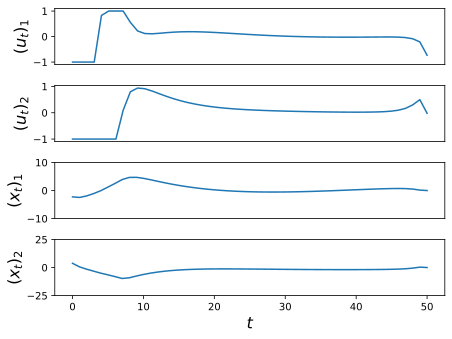

In [21]:

# Plot results.
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

f = plt.figure()

# Plot (u_t)_1.
ax = f.add_subplot(411)
plt.plot(u[0, :].value)
plt.ylabel(r"$(u_t)_1$", fontsize=16)
plt.yticks(np.linspace(-1.0, 1.0, 3))
plt.xticks([])

# Plot (u_t)_2.
plt.subplot(4, 1, 2)
plt.plot(u[1, :].value)
plt.ylabel(r"$(u_t)_2$", fontsize=16)
plt.yticks(np.linspace(-1, 1, 3))
plt.xticks([])

# Plot (x_t)_1.
plt.subplot(4, 1, 3)
x1 = x[0, :].value
plt.plot(x1)
plt.ylabel(r"$(x_t)_1$", fontsize=16)
plt.yticks([-10, 0, 10])
plt.ylim([-10, 10])
plt.xticks([])

# Plot (x_t)_2.
plt.subplot(4, 1, 4)
x2 = x[1, :].value
plt.plot(range(51), x2)
plt.yticks([-25, 0, 25])
plt.ylim([-25, 25])
plt.ylabel(r"$(x_t)_2$", fontsize=16)
plt.xlabel(r"$t$", fontsize=16)
plt.tight_layout()
plt.show()

## Covariance uncertainty


In this example we do worst-case risk analysis using CVXPY. 
Our setting is a single period Markowitz portfolio allocation problem.
We have a fixed portfolio allocation $w \in {\bf R}^n$. The return covariance $\Sigma$ is not known,
but we believe $\Sigma \in \mathcal S$.
Here $\mathcal S$ is a convex set of possible covariance matrices.
The risk is $w^T \Sigma w$, a linear function of $\Sigma$.

We can compute the worst (maximum) risk, over all possible covariance matrices by solving the convex optimization 
problem

$$
\begin{array}{ll} \hbox{maximize} & w^T\Sigma w \\
\hbox{subject to} & \Sigma \in \mathcal S, \quad \Sigma \succeq 0,
\end{array}
$$

with variable $\Sigma$.

If the worst-case risk is not too bad, you can worry less.
If not, you'll confront your worst nightmare


In the following code we solve the portfolio allocation problem

$$
\begin{array}{ll} \hbox{minimize} & w^T\Sigma_\mathrm{nom} w \\
\hbox{subject to} & {\bf 1}^Tw = 1, \quad \mu^Tw \geq 0.1, \quad \|w\|_1 \leq 2, 
\end{array}
$$

and then compute the worst-case risk under the assumption that $\mathcal S = \left\{ \Sigma^\mathrm{nom} + \Delta \,:\,
|\Delta_{ii}| =0, \;
|\Delta_{ij}| \leq 0.2
\right\}$.

We might expect that $|\Delta_{ij}| = 0.2$ for all $i \neq j$. 
This does not happen however because of the constraint that $\Sigma^\mathrm{nom} + \Delta$ is positive semidefinite.


In [22]:
# Generate data for worst-case risk analysis.
import numpy as np

np.random.seed(2)
n = 5
mu = np.abs(np.random.randn(n, 1)) / 15
Sigma = np.random.uniform(-0.15, 0.8, size=(n, n))
Sigma_nom = Sigma.T.dot(Sigma)
print("Sigma_nom =")
print(np.round(Sigma_nom, decimals=2))

Sigma_nom =
[[ 0.58  0.2   0.57 -0.02  0.43]
 [ 0.2   0.36  0.24  0.    0.38]
 [ 0.57  0.24  0.57 -0.01  0.47]
 [-0.02  0.   -0.01  0.05  0.08]
 [ 0.43  0.38  0.47  0.08  0.92]]


In [23]:
# Form and solve portfolio optimization problem.
# Here we minimize risk while requiring a 0.1 return.
import cvxpy as cp

w = cp.Variable(n)
ret = mu.T @ w
risk = cp.quad_form(w, Sigma_nom)
prob = cp.Problem(cp.Minimize(risk), [cp.sum(w) == 1, ret >= 0.1, cp.norm(w, 1) <= 2])
prob.solve(solver=cp.ECOS)
print("w =")
print(np.round(w.value, decimals=2))

w =
[-0.01  0.13  0.18  0.88 -0.18]


In [24]:
# Form and solve worst-case risk analysis problem.
Sigma = cp.Variable((n, n), PSD=True) # Positive semi-definite
Delta = cp.Variable((n, n), symmetric=True)
risk = cp.quad_form(w.value, Sigma)
prob = cp.Problem(
    cp.Maximize(risk),
    [Sigma == Sigma_nom + Delta, cp.diag(Delta) == 0, cp.abs(Delta) <= 0.2],
)
prob.solve()
print("standard deviation =", cp.sqrt(cp.quad_form(w.value, Sigma_nom)).value)
print("worst-case standard deviation =", cp.sqrt(risk).value)
print("worst-case Delta =")
print(np.round(Delta.value, decimals=2))

standard deviation = 0.16889502665649284
worst-case standard deviation = 0.42202452403535184
worst-case Delta =
[[ 0.    0.04 -0.2  -0.    0.2 ]
 [ 0.04 -0.    0.2   0.09 -0.2 ]
 [-0.2   0.2   0.    0.12 -0.2 ]
 [-0.    0.09  0.12  0.   -0.18]
 [ 0.2  -0.2  -0.2  -0.18  0.  ]]


## Model fitting


### Data model

In this example we discuss model fitting and show an example with CVXPY.
We are given data $(x_i,y_i)\in \mathcal X \times \mathcal Y$, $i=1, \ldots, m$:
* For $\mathcal X= {\bf R}^n$, $x$ is a *feature vector*.
* For $\mathcal Y= {\bf R}$,  $y$ is a (real) *outcome* or *label*.
* For $\mathcal Y= \{-1,1\}$,  $y$ is a (boolean) outcome.

Our goal is to find a *model* or *predictor*
$\psi: \mathcal X \to \mathcal Y$ so that
$\psi(x)\approx y$ *for data $(x,y)$ that we haven't seen*:
* For $\mathcal Y ={\bf R}$, $\psi$ is a *regression model*.
* For $\mathcal Y =\{-1,1\}$, $\psi$ is a *classifier*.

We choose $\psi$ based on observed data and prior knowledge.

### Loss minimization model

Let our data model be parametrized by $\theta\in {\bf R}^n$.
We define a *loss function*
$L: \mathcal X \times \mathcal Y \times {\bf R}^n \to {\bf R}$
where $L(x_i,y_i,\theta)$ is the loss (miss-fit) for the data point
$(x_i,y_i)$, using the model parameter $\theta$.

We choose $\theta$ to minimize the total loss $\sum_i L(x_i,y_i,\theta)$. Our model is then $\psi(x) = {\rm argmin}_y L(x,y,\theta)$.

### Model fitting via regularized loss minimization

An important concept in model fitting is *regularization* functions $r:{\bf R}^n \to {\bf R} \cup \{\infty\}$.
The function $r(\theta)$ measures model complexity, enforces
constraints, or represents a prior.

With regularization, we choose $\theta$ by minimizing the *regularized loss*

$$(1/m) \sum_i L(x_i,y_i,\theta)  + \lambda r(\theta).$$

For many useful cases, this is a convex problem.
Our model again is $\psi(x) = {\rm argmin}_y L(x,y,\theta)$.


In the following code we do an example of model fitting with CVXPY.
We are given (boolean) features $z\in \{0,1\}^{10}$ and (boolean) outcomes $y\in \{-1,1\}$.
We generate a new feature vector $x \in \{0,1\}^{55}$ which contains all products $z_iz_j$
(co-occurence of pairs of original features).

To fit our model, we use logistic loss, or $L(x,y,\theta) = \log (1+ \exp(-y\theta^T x))$, and an $\ell_1$ regularizer $r(\theta) = \|\theta\|_1$.
We train on $m=200$ examples and test on $100$ examples.
We plot the train and test error as we vary $\lambda$.


In [25]:
# Generate data for logistic model fitting problem.
import numpy as np

# Construct Z given X.
def pairs(Z):
    m, n = Z.shape
    k = n * (n + 1) // 2
    X = np.zeros((m, k))
    count = 0
    for i in range(n):
        for j in range(i, n):
            X[:, count] = Z[:, i] * Z[:, j]
            count += 1
    return X


np.random.seed(1)
n = 10
k = n * (n + 1) // 2
m = 200
TEST = 100
sigma = 1.9
DENSITY = 1.0
theta_true = np.random.randn(n, 1)
idxs = np.random.choice(range(n), int((1 - DENSITY) * n), replace=False)
for idx in idxs:
    theta_true[idx] = 0

Z = np.random.binomial(1, 0.5, size=(m, n))
Y = np.sign(Z.dot(theta_true) + np.random.normal(0, sigma, size=(m, 1)))
X = pairs(Z)
X = np.hstack([X, np.ones((m, 1))])
Z_test = np.random.binomial(1, 0.5, size=(TEST, n))
Y_test = np.sign(Z_test.dot(theta_true) + np.random.normal(0, sigma, size=(TEST, 1)))
X_test = pairs(Z_test)
X_test = np.hstack([X_test, np.ones((TEST, 1))])


In [26]:
# Form model fitting problem with logistic loss and L1 regularization.
import cvxpy as cp


theta = cp.Variable((k + 1, 1))
lambd = cp.Parameter(nonneg=True)
loss = cp.sum(
    cp.log_sum_exp(cp.hstack([np.zeros((m, 1)), -cp.multiply(Y, X @ theta)]), axis=1)
)
reg = cp.norm(theta[:k], 1)
prob = cp.Problem(cp.Minimize(loss / m + lambd * reg))

# Compute a trade-off curve and record train and test error.
TRIALS = 100
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-4, 0, TRIALS)
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve(solver=cp.SCS)
    train_error[i] = (
        np.sign(Z.dot(theta_true)) != np.sign(X.dot(theta.value))
    ).sum() / m
    test_error[i] = (
        np.sign(Z_test.dot(theta_true)) != np.sign(X_test.dot(theta.value))
    ).sum() / TEST

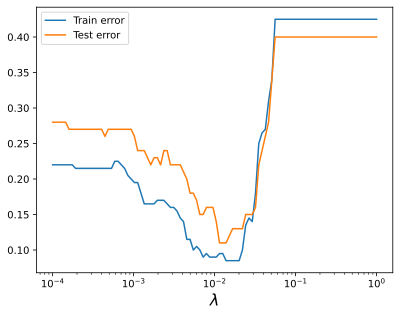

In [27]:
# Plot the train and test error over the trade-off curve.
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale("log")
plt.legend(loc="upper left")
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()


Below we plot $|\theta_{k}|$, $k=1,\ldots,55$, for the $\lambda$ that minimized the test error. Each $|\theta_{k}|$ is placed at position $(i,j)$ where $z_iz_j = x_k$. Notice that many $\theta_{k}$ are $0$, as we would expect with $\ell_1$ regularization.


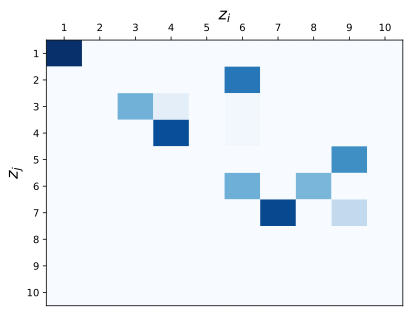

In [28]:
# Solve model fitting problem with the lambda that minimizes test error.
idx = np.argmin(test_error)
lambd.value = lambda_vals[idx]
prob.solve(solver=cp.SCS)

# Plot the absolute value of the entries in theta corresponding to each feature.
P = np.zeros((n, n))
count = 0
for i in range(n):
    for j in range(i, n):
        P[i, j] = np.abs(theta.value[count])[0]
        count += 1
row_labels = range(1, n + 1)
column_labels = range(1, n + 1)

fig, ax = plt.subplots()
heatmap = ax.pcolor(P, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(P.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(P.shape[0]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)

plt.xlabel(r"$z_i$", fontsize=16)
ax.xaxis.set_label_position("top")
plt.ylabel(r"$z_j$", fontsize=16)
plt.show()

## Total variation in-painting

### Grayscale Images

A grayscale image is represented as an $m \times n$ matrix of intensities
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the values $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixel values.
Our job is to *in-paint* the image by guessing the missing pixel values,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ U_{i,j+1}-U_{ij} \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.

We load the original image and the corrupted image and construct the Known matrix. Both images are displayed below. The corrupted image has the missing pixels whited out.


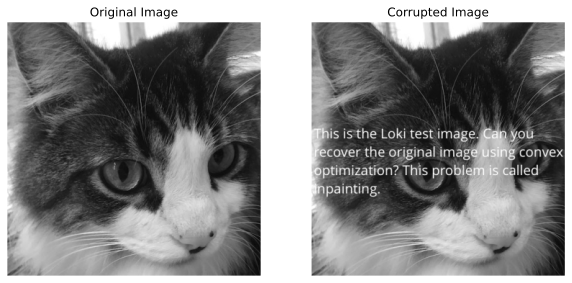

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Load the images.
u_orig = plt.imread("data/loki512.png")
u_corr = plt.imread("data/loki512_corrupted.png")
rows, cols = u_orig.shape


%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(u_orig, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(u_corr, cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');


The total variation in-painting problem can be easily expressed in CVXPY. We use the solver SCS, which scales to larger problems than ECOS does.


In [30]:
# Recover the original image using total variation in-painting.
import cvxpy as cp

# known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
known = np.zeros((rows, cols))
for i in range(rows):
    for j in range(cols):
         if u_orig[i, j] == u_corr[i, j]:
            known[i, j] = 1

U = cp.Variable(shape=(rows, cols))
obj = cp.Minimize(cp.tv(U))
constraints = [cp.multiply(known, U) == cp.multiply(known, u_corr)]
prob = cp.Problem(obj, constraints)

# Use SCS to solve the problem.
prob.solve(verbose=True, solver=cp.SCS,max_iters=50)
print("optimal objective value: {}".format(obj.value))

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 17 11:24:20 AM: Your problem has 262144 variables, 1 constraints, and 0 parameters.
(CVXPY) Nov 17 11:24:20 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 17 11:24:20 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 17 11:24:20 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 17 11:24:20 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 17 11:24:20 AM: Compiling problem (target solver=SCS).
(

/root/data/miniconda/envs/cvx/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


After solving the problem, the in-painted image is stored in `U.value`. We display the in-painted image and the intensity difference between the original and in-painted images. The intensity difference is magnified by a factor of 10 so it is more visible.


In [22]:
# U = np.load("data/in_painted1.npy")

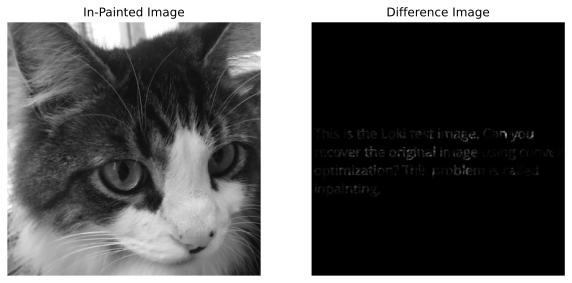

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Display the in-painted image.
ax[0].imshow(U.value, cmap='gray');
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = 10*np.abs(u_orig - U.value)
ax[1].imshow(img_diff, cmap='gray');
ax[1].set_title("Difference Image")
ax[1].axis('off');

### Color Images

For color images, the in-painting problem is similar to the grayscale case. A color image is represented as an $m \times n \times 3$ matrix of RGB values
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the pixels $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixels. Each pixel $U^\mathrm{orig}_{ij}$ is a vector in ${\bf R}^3$ of RGB values.
Our job is to *in-paint* the image by guessing the missing pixels,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n \times 3}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ 
 U_{i,j+1}-U_{ij} 
 \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.

We load the original image and construct the Known matrix by randomly selecting 30% of the pixels to keep and discarding the others. The original and corrupted images are displayed below. The corrupted image has the missing pixels blacked out.


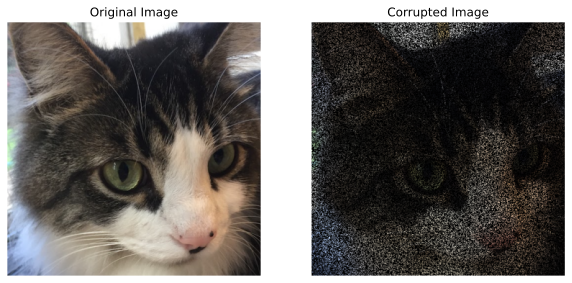

In [32]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
# Load the images.
u_orig = plt.imread("data/loki512color.png")
rows, cols, colors = u_orig.shape

# known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
# The known matrix is initialized randomly.
known = np.zeros((rows, cols, colors))
for i in range(rows):
    for j in range(cols):
        if np.random.random() > 0.7:
            for k in range(colors):
                known[i, j, k] = 1        
u_corr = known * u_orig

# Display the images.
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(u_orig, cmap='gray');
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(u_corr);
ax[1].set_title("Corrupted Image")
ax[1].axis('off');


We express the total variation color in-painting problem in CVXPY using three matrix variables (one for the red values, one for the blue values, and one for the green values). We use the solver SCS; the solvers ECOS and CVXOPT don't scale to this large problem.


In [33]:
# Recover the original image using total variation in-painting.
import cvxpy as cp

variables = []
constraints = []
for i in range(colors):
    U = cp.Variable(shape=(rows, cols))
    variables.append(U)
    constraints.append(cp.multiply(known[:, :, i], U) == cp.multiply(known[:, :, i], u_corr[:, :, i]))

prob = cp.Problem(cp.Minimize(cp.tv(*variables)), constraints)
prob.solve(verbose=True, solver=cp.SCS,max_iters=50)
print("optimal objective value: {}".format(prob.value))

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 17 11:25:57 AM: Your problem has 786432 variables, 3 constraints, and 0 parameters.
(CVXPY) Nov 17 11:25:57 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 17 11:25:57 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 17 11:25:57 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 17 11:25:57 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 17 11:25:57 AM: Compiling problem (target solver=SCS).
(

(CVXPY) Nov 17 11:25:59 AM: Applying reduction SCS
(CVXPY) Nov 17 11:26:00 AM: Finished problem compilation (took 2.726e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Nov 17 11:26:00 AM: Invoking solver SCS  to obtain a solution.
------------------------------------------------------------------
	       SCS v3.2.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 1047553, constraints m: 2614279
cones: 	  z: primal zero / dual free vars: 786432
	  q: soc vars: 1827847, qsize: 261121
settings: eps_abs: 1.0e-05, eps_rel: 1.0e-05, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 50, normalize: 1, rho_x: 1.00e-06
	  acceleration_l

After solving the problem, the RGB values of the in-painted image are stored in the value fields of the three variables. We display the in-painted image and the difference in RGB values at each pixel of the original and in-painted image. Though the in-painted image looks almost identical to the original image, you can see that many of the RGB values differ.


In [26]:
# rec_arr = np.load('./data/in_painted2.npy')

(-0.5, 511.5, 511.5, -0.5)

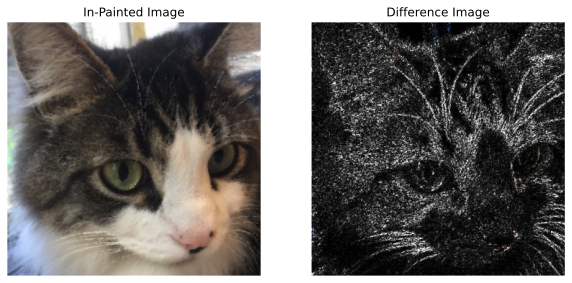

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

rec_arr = np.zeros((rows, cols, colors))
for i in range(colors):
    rec_arr[:, :, i] = variables[i].value
rec_arr = np.clip(rec_arr, 0, 1)

fig, ax = plt.subplots(1, 2,figsize=(10, 5))
ax[0].imshow(rec_arr)
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = np.clip(10 * np.abs(u_orig - rec_arr), 0, 1)
ax[1].imshow(img_diff)
ax[1].set_title("Difference Image")
ax[1].axis('off')

# Disciplined geometric programming

## DGP fundamentals

This notebook will introduce you to the fundamentals of **disciplined geometric programming** (**DGP**), which lets you formulate and solve *log-log convex programs* (LLCPs) in CVXPY.

LLCPs are problems that become convex after the variables, objective functions, and constraint functions are replaced with their logs, an operation that we refer to as a log-log transformation. LLCPs generalize geometric programming.


In [35]:
import cvxpy as cp

### 1. Log-log curvature

Just as every Expression in CVXPY has a curvature (constant, affine, convex, concave, or unknown), every Expression also has a log-log curvature.

A function $f : D \subseteq \mathbf{R}^{n}_{++} \to \mathbf{R}$ is said to be **log-log convex** if the function $F(u)=\log f(e^u)$, with domain $\{u \in \mathbf{R}^n : e^u \in D\}$, is convex (where $\mathbf{R}^{n}_{++}$ denotes the set of positive reals and the logarithm and exponential are meant elementwise); the function $F$ is called the log-log transformation of $f$. The function $f$ is **log-log concave** if $F$ is concave, and it is **log-log affine** if $F$ is affine.

Notice that if a function has log-log curvature, then its domain and range can only include positive numbers.

The log-log curvature of an `Expression` can be accessed via its `.log_log_curvature` attribute. For an `Expression` to have known log-log curvature, all of the `Constant`s, `Variable`s, and `Parameter`s it refers to must be elementwise positive.


In [36]:
# Only elementwise positive constants are allowed in DGP.
c = cp.Constant(1.0)
print(c, c.log_log_curvature)

c = cp.Constant([1.0, 2.0])
print(c, c.log_log_curvature)

c = cp.Constant([1.0, 0.0])
print(c, c.log_log_curvature)

c = cp.Constant(-2.0)
print(c, c.log_log_curvature)

1.0 LOG-LOG CONSTANT
[1. 2.] LOG-LOG CONSTANT
[1. 0.] UNKNOWN
-2.0 UNKNOWN


In [30]:
# Variables and parameters must be positive, ie, they must be constructed with the option `pos=True`
v = cp.Variable(pos=True)
print(v, v.log_log_curvature)

v = cp.Variable()
print(v, v.log_log_curvature)

p = cp.Parameter(pos=True)
print(p, p.log_log_curvature)

p = cp.Parameter()
print(p, p.log_log_curvature)

var4965 LOG-LOG AFFINE
var4966 UNKNOWN
param4967 LOG-LOG CONSTANT
param4968 UNKNOWN


### Functions from geometric programming

A function $f(x)$ is log-log affine if and only if it is given by

$$
f(x) = cx_1^{a_1}x_2^{a_2} \ldots x_n^{a_n},
$$

where $c > 0$ and the $a_i$ are real numbers. In the context of geometric programming, such a function is called
a monomial.


In [37]:
x = cp.Variable(shape=(3,), pos=True, name="x")
c = 2.0
a = [0.5, 2.0, 1.8]

monomial = c * x[0] ** a[0] * x[1] ** a[1] * x[2] ** a[2]
# Monomials are not convex.
assert not monomial.is_convex()
# print(monomial.is_convex())
# They are, however, log-log affine.
print(monomial, ":", monomial.log_log_curvature)
assert monomial.is_log_log_affine()

2.0 @ power(x[0], 0.5) @ power(x[1], 2.0) @ power(x[2], 1.8) : LOG-LOG AFFINE


A sum of monomial functions is log-log convex; in the context of geometric programming, such a function is called a posynomial. There are functions that are not posynomials that are still log-log convex.


In [40]:
x = cp.Variable(pos=True, name="x")
y = cp.Variable(pos=True, name="y")

constant = cp.Constant(2.0)
monomial = constant * x * y
posynomial = monomial + (x ** 1.5) * (y ** -1)
reciprocal = posynomial ** -1
unknown = reciprocal + posynomial

print(constant, ":", constant.log_log_curvature)
print(monomial, ":", monomial.log_log_curvature)
print(posynomial, ":", posynomial.log_log_curvature)
print(reciprocal, ":", reciprocal.log_log_curvature)
print(unknown, ":", unknown.log_log_curvature)

2.0 : LOG-LOG CONSTANT
2.0 @ x @ y : LOG-LOG AFFINE
2.0 @ x @ y + power(x, 1.5) @ power(y, -1.0) : LOG-LOG CONVEX
power(2.0 @ x @ y + power(x, 1.5) @ power(y, -1.0), -1.0) : LOG-LOG CONCAVE
power(2.0 @ x @ y + power(x, 1.5) @ power(y, -1.0), -1.0) + 2.0 @ x @ y + power(x, 1.5) @ power(y, -1.0) : UNKNOWN


### 2. Log-log curvature ruleset

CVXPY has a library of atomic functions with known log-log curvature and monotonicity. It uses this information to
tag every `Expression`, i.e., every composition of atomic functions, with a log-log curvature. In particular, 

A function $f(expr_1,expr_2,...,expr_n)$ is log-log convex if  $f$ is a log-log convex function and for each expri one of the following conditions holds:

$f$ is increasing in argument i and $expr_i$ is log-log convex.
$f$ is decreasing in argument $i$ and $expr_i$ is log-log concave.
$expr_i$ is log-log affine.

A function $f(expr_1,expr_2,...,expr_n)$ is log-log concave if  $f$ is a log-log concave function and for each $expr_i$ one of the following conditions holds:

$f$ is increasing in argument $i$ and $expr_i$ is log-log concave.
$f$ is decreasing in argument $i$ and $expr_i$ is log-log convex.
$expr_i$ is log-log affine.

A function $f(expr_1,expr_2,...,expr_n)$ is log-log affine if $f$ is an log-log affine function and each $expr_i$ is log-log affine.

If none of the three rules apply, the expression $f(expr_1,expr_2,...,expr_n)$ is marked as having unknown curvature.

If an Expression satisfies the composition rule, we colloquially say that the `Expression` “is DGP.” You can check whether an `Expression` is DGP by calling the method `is_dgp()`.

In [33]:
x = cp.Variable(pos=True, name="x")
y = cp.Variable(pos=True, name="y")

monomial = 2.0 * x * y
posynomial = monomial + (x ** 1.5) * (y ** -1)

print(monomial, "is dgp?", monomial.is_dgp())
print(posynomial, "is dgp?", posynomial.is_dgp())

2.0 @ x @ y is dgp? True
2.0 @ x @ y + power(x, 1.5) @ power(y, -1.0) is dgp? True


### 3. DGP problems

An LLCP is an optimization problem of the form

$$
\begin{equation}
\begin{array}{ll}
\hbox{minimize} & f_0(x) \\
\hbox{subject to} & f_i(x) \leq \tilde{f_i}, \quad i=1, \ldots, m\\
& g_i(x) = \tilde{g_i}, \quad i=1, \ldots, p,
\end{array}
\end{equation}
$$

where the functions $f_i$ are log-log convex, $\tilde{f_i}$ are log-log concave, and the functions $g_i$ and $\tilde{g_i}$ are log-log affine. An optimization problem with constraints of the above form in which the goal is to maximize a log-log concave function is also an LLCP.

A problem is DGP if additionally all the functions are DGP. You can check whether a CVXPY `Problem` is DGP by calling
its `.is_dgp()` method.


In [34]:
x = cp.Variable(pos=True, name="x")
y = cp.Variable(pos=True, name="y")
z = cp.Variable(pos=True, name="z")

objective_fn = x * y * z
constraints = [
  4 * x * y * z + 2 * x * z <= 10, x <= 2*y, y <= 2*x, z >= 1]
assert objective_fn.is_log_log_concave()
assert all(constraint.is_dgp() for constraint in constraints)
problem = cp.Problem(cp.Maximize(objective_fn), constraints)

print(problem)
print("Is this problem DGP?", problem.is_dgp())

maximize x @ y @ z
subject to 4.0 @ x @ y @ z + 2.0 @ x @ z <= 10.0
           x <= 2.0 @ y
           y <= 2.0 @ x
           1.0 <= z
Is this problem DGP? True


### Solving DGP problems

You can solve a DGP `Problem` by calling its `solve` method with `gp=True`.


In [35]:
problem.solve(solver=cp.ECOS,gp=True)
print("Optimal value:", problem.value)
print(x, ":", x.value)
print(y, ":", y.value)
print(z, ":", z.value)
print("Dual values: ", list(c.dual_value for c in constraints))

Optimal value: 1.9999999926114256
x : 0.9999999989773863
y : 1.9999999528702908
z : 1.0000000208931816
Dual values:  [1.1111111199285972, 1.9486357660369777e-09, 0.1111111217007257, 0.11111112213462261]


If you forget to supply `gp=True`, an error will be raised.


In [36]:
try:
    problem.solve()
except cp.DCPError as e:
    print(e)

Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
x @ y
However, the problem does follow DGP rules. Consider calling solve() with `gp=True`.


## Maximizing the volume of a box

*This example is adapted from Boyd, Kim, Vandenberghe, and Hassibi,* "[A Tutorial on Geometric Programming](https://web.stanford.edu/~boyd/papers/pdf/gp_tutorial.pdf)."

In this example, we maximize the shape of a box with height $h$, width $w$, and depth $d$, with limits on the wall area $2(hw + hd)$
and the floor area $wd$, subject to bounds on the aspect ratios $h/w$ and $w/d$. The optimization problem is

$$
\begin{array}{ll}
\hbox{maximize} & hwd \\
\hbox{subject to} & 2(hw + hd) \leq A_{\text wall}, \\
& wd \leq A_{\text flr}, \\
& \alpha \leq h/w \leq \beta, \\
& \gamma \leq d/w \leq \delta.
\end{array}
$$


In [41]:
import cvxpy as cp

# Problem data.
A_wall = 100
A_flr = 10
alpha = 0.5
beta = 2
gamma = 0.5
delta = 2

h = cp.Variable(pos=True, name="h")
w = cp.Variable(pos=True, name="w")
d = cp.Variable(pos=True, name="d")

volume = h * w * d
wall_area = 2 * (h * w + h * d)
flr_area = w * d
hw_ratio = h/w
dw_ratio = d/w
constraints = [
    wall_area <= A_wall,
    flr_area <= A_flr,
    hw_ratio >= alpha,
    hw_ratio <= beta,
    dw_ratio >= gamma,
    dw_ratio <= delta
]
problem = cp.Problem(cp.Maximize(volume), constraints)
print(problem)


maximize h @ w @ d
subject to 2.0 @ (h @ w + h @ d) <= 100.0
           w @ d <= 10.0
           0.5 <= h / w
           h / w <= 2.0
           0.5 <= d / w
           d / w <= 2.0


In [45]:
assert not problem.is_dcp()
assert problem.is_dgp()
problem.solve(solver=cp.ECOS,gp=True)
problem.value

77.45966630665183

# Disciplined quasiconvex programming

## Fractional optimization

This notebook shows how to solve a simple *concave fractional problem*, in which the objective is to maximize the ratio of a nonnegative concave function and a positive
convex function. Concave fractional problems are quasiconvex programs (QCPs). They can be specified using disciplined quasiconvex programming ([DQCP](https://www.cvxpy.org/tutorial/dqcp/index.html)), and hence can be solved using CVXPY.


In [46]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt


Our goal is to minimize the function

$$\frac{\sqrt{x}}{\exp(x)}.$$

This function is not concave, but it is quasiconcave, as can be seen by inspecting its graph.


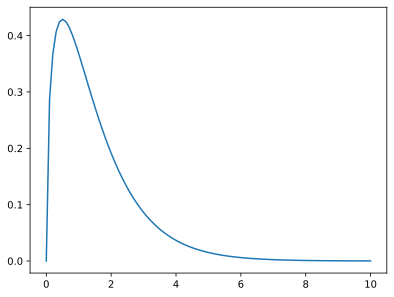

In [47]:
mesh = np.linspace(0, 10, 100)
plt.plot(mesh,np.sqrt(mesh) / np.exp(mesh))
plt.show()

The below code specifies and solves the QCP, using DQCP. The concave fraction function is DQCP-compliant, because the ratio atom is quasiconcave (actually, quasilinear), increasing in the numerator when the denominator is positive, and decreasing in the denominator when the numerator is nonnegative.

In [52]:
x = cp.Variable()
concave_fractional_fn = cp.sqrt(x) / cp.exp(x)
problem = cp.Problem(cp.Maximize(concave_fractional_fn))
assert  problem.is_dqcp()
problem.solve(solver=cp.ECOS,qcp=True)

concave_fractional_fn.value

0.4288819424791909

## Minimum-length least squares

This notebook shows how to solve a *minimum-length least squares* problem, which finds a minimum-length vector $x \in \mathbf{R}^n$ achieving small mean-square error (MSE) for a particular least squares problem:

\begin{equation*}
\begin{array}{ll}
\hbox{minimize} & \mathrm{len}(x) \\
\hbox{subject to} & \frac{1}{n}\|Ax - b\|_2^2 \leq \epsilon,
\end{array}
\end{equation*}

where the variable is $x$ and the problem data are $n$, $A$, $b$, and $\epsilon$.

This is a quasiconvex program (QCP). It can be specified using disciplined quasiconvex programming ([DQCP](https://www.cvxpy.org/tutorial/dqcp/index.html)), and it can therefore be solved using CVXPY.


In [53]:
import cvxpy as cp
import numpy as np

n = 10
np.random.seed(1)
A = np.random.randn(n, n)
x_star = np.random.randn(n)
b = A @ x_star
epsilon = 1e-2

And the next cell constructs and solves the QCP.


In [58]:
x = cp.Variable(n)
mse = cp.sum_squares(A @ x - b)/n
problem = cp.Problem(cp.Minimize(cp.length(x)), [mse <= epsilon])
print("Is problem DQCP?: ", problem.is_dqcp())

problem.solve(solver=cp.ECOS,qcp=True)
print("Found a solution, with length: ", problem.value)
print("MSE: ", mse.value)
print("x: ", x.value)


Is problem DQCP?:  True
Found a solution, with length:  8.0
MSE:  0.00926009328813662
x:  [-2.58366030e-01  1.38434327e+00  2.10714108e-01  9.44811159e-01
 -1.14622208e+00  1.51283929e-01  6.62931941e-01 -1.16358584e+00
  2.78132907e-13 -1.76314786e-13]


# Derivatives

## Derivatives fundamentals

This notebook will introduce you to the fundamentals of computing the derivative of the solution map to optimization problems. The derivative can be used for **sensitivity analysis**, to see how a solution would change given small changes to the parameters, and to compute **gradients** of scalar-valued functions of the solution.

In this notebook, we will consider a simple disciplined geometric program. The geometric program under consideration is

$$
\begin{equation}
\begin{array}{ll}
\hbox{minimize} & 1/(xyz) \\
\hbox{subject to} & a(xy + xz + yz) \leq b\\
& x \geq y^c,
\end{array}
\end{equation}
$$

where $x \in \mathbf{R}_{++}$, $y \in \mathbf{R}_{++}$, and $z \in \mathbf{R}_{++}$ are the variables, and $a \in \mathbf{R}_{++}$, $b \in \mathbf{R}_{++}$ and $c \in \mathbf{R}$ are the parameters. The vector
$$
\alpha = \begin{bmatrix} a \\ b \\ c \end{bmatrix}
$$
is the vector of parameters.


In [60]:
import cvxpy as cp


x = cp.Variable(pos=True)
y = cp.Variable(pos=True)
z = cp.Variable(pos=True)

a = cp.Parameter(pos=True)
b = cp.Parameter(pos=True)
c = cp.Parameter()

objective_fn = 1/(x*y*z)
objective = cp.Minimize(objective_fn)
constraints = [a*(x*y + x*z + y*z) <= b, x >= y**c]
problem = cp.Problem(objective, constraints)

problem.is_dgp(dpp=True)


True

Notice the keyword argument `dpp=True`. The parameters must enter in the DGP problem acording to special rules, which we refer to as `dpp`. The DPP rules are described in an [online tutorial](https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming).

Next, we solve the problem, setting the parameters $a$, $b$ and $c$ to $2$, $1$, and $0.5$.


In [45]:
# !pip install diffcp 

In [61]:
a.value = 2.0
b.value = 1.0
c.value = 0.5
problem.solve(solver=cp.SCS,gp=True, requires_grad=True)

print(x.value)
print(y.value)
print(z.value)


0.561214321862524
0.3149615159709403
0.36892053139652614


Notice the keyword argument ``requires_grad=True``; this is necessary to subsequently compute derivatives.


### Solution map


The **solution map** of the above problem is a function
$$\mathcal{S} : \mathbf{R}^2_{++} \times \mathbf{R} \to \mathbf{R}^3_{++}$$
which maps the parameter vector to the vector of optimal solutions
$$
\mathcal S(\alpha) = \begin{bmatrix} x(\alpha) \\ y(\alpha) \\ z(\alpha)\end{bmatrix}.
$$

Here, $x(\alpha)$, $y(\alpha)$, and $z(\alpha)$ are the optimal values of the variables corresponding to the parameter vector.

As an example, we just saw that
$$
\mathcal S((2.0, 1.0, 0.5)) = \begin{bmatrix} 0.5612 \\ 0.3150 \\ 0.3690 \end{bmatrix}.
$$

### Sensitivity analysis

When the solution map is differentiable, we can use its derivative
$$
\mathsf{D}\mathcal{S}(\alpha) \in \mathbf{R}^{3 \times 3}
$$
to perform a **sensitivity analysis**, which studies how the solution would change given small changes to the parameters.

Suppose we perturb the parameters by a vector of small magnitude $\mathsf{d}\alpha \in \mathbf{R}^3$. We can approximate the change $\Delta$ in the solution due to the perturbation using the derivative, as
$$
\Delta = \mathcal{S}(\alpha + \mathsf{d}\alpha) - \mathcal{S}(\alpha) \approx \mathsf{D}\mathcal{S}(\alpha) \mathsf{d}\alpha.
$$

We can compute this in CVXPY, as follows.

Partition the perturbation as
$$
\mathsf{d}\alpha = \begin{bmatrix} \mathsf{d}a \\ \mathsf{d}b \\ \mathsf{d}c\end{bmatrix}.
$$

We set the ``delta`` attributes of the parameters to their perturbations, and then call the ``derivative`` method.




In [63]:
da, db, dc = 1e-2, 1e-2, 1e-2
a.delta = da
b.delta = db
c.delta = dc
problem.derivative()


The ``derivative`` method populates the ``delta`` attributes of the variables as a side-effect, with the predicted change in the variable. We can compare the predictions to the actual solution of the perturbed problem.


In [64]:
x_hat = x.value + x.delta
y_hat = y.value + y.delta
z_hat = z.value + z.delta

a.value += da
b.value += db
c.value += dc

problem.solve(solver=cp.SCS,gp=True)
print('x: predicted {0:.5f} actual {1:.5f}'.format(x_hat, x.value))
print('y: predicted {0:.5f} actual {1:.5f}'.format(y_hat, y.value))
print('z: predicted {0:.5f} actual {1:.5f}'.format(z_hat, z.value))

a.value -= da
b.value -= db
c.value -= dc

x: predicted 0.55728 actual 0.55733
y: predicted 0.31782 actual 0.31782
z: predicted 0.37181 actual 0.37178



In this case, the predictions and the actual solutions are fairly close.


### Gradient

We can compute gradient of a scalar-valued function of the solution with respect to the parameters. Let $f : \mathbf{R}^{3} \to \mathbf{R}$, and suppose we want to compute the gradient of the composition $f \circ \mathcal S$. By the chain rule,
$$
\nabla f(S(\alpha)) = \mathsf{D}^T\mathcal{S}(\alpha) \begin{bmatrix}\mathsf{d}x \\ \mathsf{d}y \\ \mathsf{d}z\end{bmatrix},
$$
where $\mathsf{D}^T\mathcal{S}$ is the adjoint (or transpose) of the derivative operator, and $\mathsf{d}x$, $\mathsf{d}y$, and $\mathsf{d}z$ are the partial derivatives of $f$ with respect to its arguments.

We can compute the gradient in CVXPY, using the ``backward`` method. As an example, suppose
$$
f(x, y, z) = \frac{1}{2}(x^2 + y^2 + z^2),
$$
so that $\mathsf{d}x = x$, $\mathsf{d}y = y$, and $\mathsf{d}z = z$. Let $\mathsf{d}\alpha = \nabla f(S(\alpha))$,
and suppose we subtract $\eta \mathsf{d}\alpha$ from the parameter, where $\eta$ is a positive constant. Using the following code, we can compare $f(\mathcal S(\alpha - \eta \mathsf{d}\alpha))$ with the value predicted by the gradient,
$$
f(\mathcal S(\alpha - \eta \mathsf{d}\alpha)) \approx f(\mathcal S(\alpha)) - \eta \mathsf{d}\alpha^T\mathsf{d}\alpha.
$$


In [65]:
problem.solve(solver=cp.SCS,gp=True, requires_grad=True)

def f(x, y, z):
    return 1/2*(x**2 + y**2 + z**2)

original = f(x, y, z).value

x.gradient = x.value
y.gradient = y.value
z.gradient = z.value
problem.backward()

In [66]:
eta = 0.5
dalpha = cp.vstack([a.gradient, b.gradient, c.gradient])
predicted = float((original - eta*dalpha.T @ dalpha).value.item())

a.value -= eta*a.gradient
b.value -= eta*b.gradient
c.value -= eta*c.gradient
problem.solve(solver=cp.SCS,gp=True)
actual = f(x, y, z).value

print('original {0:.5f} predicted {1:.5f} actual {2:.5f}'.format(
       original, predicted, actual))

original 0.27513 predicted 0.22703 actual 0.22939


## Structured prediction

<!-- \newcommand{\reals}{\mathbf{R}}
\newcommand{\ones}{\mathbf{1}} -->

In this example, we fit a regression model to structured data, using an LLCP.
The training dataset $\  D$ contains $N$ input-output pairs $(x, y)$,
where $x \in \mathbf{R}^{n}_{++}$ is an input and $y \in \mathbf{R}^{m}_{++}$ is an
outputs. The entries of each output $y$ are sorted in ascending order, meaning
$y_1 \leq y_2 \leq \cdots y_m$.

Our regression model $\phi : \mathbf{R}^{n}_{++} \to \mathbf{R}^{m}_{++}$ takes as
input a vector $x \in \mathbf{R}^{n}_{++}$, and solves an LLCP to produce a
prediction $\hat y \in \mathbf{R}^{m}_{++}$. In particular, the solution of the
LLCP is model's prediction. The model is of the form
$$
\begin{equation}
\begin{array}{lll}
\phi(x) = &
\hbox{argmin} & \mathbf{1}^T (z/y + y / z) \\
& \hbox{subject to} &  y_i \leq y_{i+1}, \quad i=1, \ldots, m-1 \\
&& z_i = c_i x_1^{A_{i1}}x_2^{A_{i2}}\cdots x_n^{A_{in}}, \quad i = 1, \ldots, m.
\end{array}
\end{equation}
$$
Here, the minimization is over $y \in \mathbf{R}^{m}_{++}$ and an auxiliary
variable $z \in \mathbf{R}^{m}_{++}$, $\phi(x)$ is the optimal value of $y$, and
the parameters are $c \in \mathbf{R}^{m}_{++}$ and $A \in \mathbf{R}^{m \times n}$. The
ratios in the objective are meant elementwise, as is the inequality $y \leq z$, and
$\mathbf{1}$ denotes the vector of all ones. Given a vector $x$, this model finds a
sorted vector $\hat y$ whose entries are close to monomial functions of $x$
(which are the entries of $z$), as measured by the fractional error.


The training loss
$\mathcal{L}(\phi)$ of the model on the training set is the mean squared loss
$$
\mathcal{L}(\phi) = \frac{1}{N}\sum_{(x, y) \in \mathcal D} \|y - \phi(x)\|_2^2.
$$
We emphasize that $\mathcal{L}(\phi)$ depends on $c$ and $A$.
In this example, we fit the parameters $c$ and $A$ in the LLCP 
to minimize the training loss $\mathcal{L}(\phi)$.

**Fitting.** We fit the parameters by an iterative projected
gradient descent method on $\mathcal L(\phi)$. In each iteration, we first
compute predictions $\phi(x)$ for each input in the training set; this requires
solving $N$ LLCPs. Next, we evaluate the training loss $\mathcal L(\phi)$. To
update the parameters, we compute the gradient $\nabla \mathcal L(\phi)$ of the
training loss with respect to the parameters $c$ and $A$. This
requires differentiating through the solution map of the LLCP. We can compute this gradient efficiently, using the ``backward`` method in CVXPY
(or CVXPY Layers). Finally, we subtract
a small multiple of the gradient from the parameters. Care must be taken to
ensure that $c$ is strictly positive; this can be done by clamping the entries
of $c$ at some small threshold slightly above zero. We run this method for
a fixed number of iterations.

This example is described in the paper [Differentiating through Log-Log Convex Programs](http://web.stanford.edu/~boyd/papers/pdf/diff_llcvx.pdf).

Shane Barratt formulated the idea of using an optimization layer to regress on sorted vectors.

**Requirements.**
This example requires PyTorch and CvxpyLayers >= v0.1.3.


In [ ]:
! pip install cvxlayers
! conda install pytorch -c pytorch

In [67]:
from cvxpylayers.torch import CvxpyLayer
import torch
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

torch.set_default_dtype(torch.float64)
%matplotlib inline


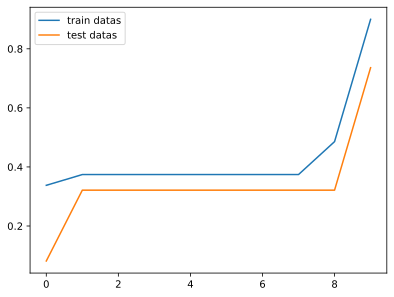

In [68]:
### Data generation
n = 20
m = 10
# Number of training input-output pairs
N = 100
# Number of validation pairs
N_val = 50
torch.random.manual_seed(243)
np.random.seed(243)

normal = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(n), torch.eye(n))
lognormal = lambda batch: torch.exp(normal.sample(torch.tensor([batch])))

A_true = torch.randn((m, n)) / 10
c_true = np.abs(torch.randn(m))

def generate_data(num_points, seed):
    torch.random.manual_seed(seed)
    np.random.seed(seed)
    
    latent = lognormal(num_points)
    noise = lognormal(num_points)
    inputs = noise + latent

    input_cp = cp.Parameter(pos=True, shape=(n,))
    prediction = cp.multiply(c_true.numpy(), cp.gmatmul(A_true.numpy(), input_cp))
    y = cp.Variable(pos=True, shape=(m,))
    objective_fn = cp.sum(prediction / y + y/prediction)
    constraints = []
    for i in range(m-1):
        constraints += [y[i] <= y[i+1]]
    problem = cp.Problem(cp.Minimize(objective_fn), constraints)
    
    outputs = []
    for i in range(num_points):
        input_cp.value = inputs[i, :].numpy()
        problem.solve(cp.SCS, gp=True)
        outputs.append(y.value)
    return inputs, torch.stack([torch.tensor(t) for t in outputs])

train_inputs, train_outputs = generate_data(N, 243)
plt.plot(train_outputs[0, :].numpy(),label='train datas')

val_inputs, val_outputs = generate_data(N_val, 0)
plt.plot(val_outputs[0, :].numpy(),label='test datas')
plt.legend()


### Monomial fit to each component

We will initialize the parameters in our LLCP model by fitting monomials to the training data, without enforcing the monotonicity constraint.


In [69]:
log_c = cp.Variable(shape=(m,1))
theta = cp.Variable(shape=(n, m))
inputs_np = train_inputs.numpy()
log_outputs_np = np.log(train_outputs.numpy()).T
log_inputs_np = np.log(inputs_np).T
offsets = cp.hstack([log_c]*N)

cp_preds = theta.T @ log_inputs_np + offsets
objective_fn = (1/N) * cp.sum_squares(cp_preds - log_outputs_np)
lstq_problem = cp.Problem(cp.Minimize(objective_fn))

lstq_problem.is_dcp()

lstq_problem.solve(verbose=True)

c = torch.exp(torch.tensor(log_c.value)).squeeze()
lstsq_val_preds = []
for i in range(N_val):
    inp = val_inputs[i, :].numpy()
    pred = cp.multiply(c,cp.gmatmul(theta.T.value, inp))
    lstsq_val_preds.append(pred.value)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 17 11:45:15 AM: Your problem has 210 variables, 0 constraints, and 0 parameters.
(CVXPY) Nov 17 11:45:15 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 17 11:45:15 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 17 11:45:15 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 17 11:45:15 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 17 11:45:15 AM: Compiling problem (target solver=OSQP).
(CV


### Fitting


In [70]:
A_param = cp.Parameter(shape=(m, n))
c_param = cp.Parameter(pos=True, shape=(m,))
x_slack = cp.Variable(pos=True, shape=(n,))
x_param = cp.Parameter(pos=True, shape=(n,))
y = cp.Variable(pos=True, shape=(m,))

prediction = cp.multiply(c_param, cp.gmatmul(A_param, x_slack))
objective_fn = cp.sum(prediction / y + y / prediction)
constraints = [x_slack == x_param]
for i in range(m-1):
    constraints += [y[i] <= y[i+1]]
problem = cp.Problem(cp.Minimize(objective_fn), constraints)
problem.is_dgp(dpp=True)

A_param.value = np.random.randn(m, n)
x_param.value = np.abs(np.random.randn(n))
c_param.value = np.abs(np.random.randn(m))

layer = CvxpyLayer(problem, parameters=[A_param, c_param, x_param], variables=[y], gp=True)

torch.random.manual_seed(1)
A_tch = torch.tensor(theta.T.value)
A_tch.requires_grad_(True)
c_tch = torch.tensor(np.squeeze(np.exp(log_c.value)))
c_tch.requires_grad_(True)
train_losses = []
val_losses = []

lam1 = torch.tensor(1e-1)
lam2 = torch.tensor(1e-1)

opt = torch.optim.SGD([A_tch, c_tch], lr=5e-2)
for epoch in range(10):
    preds = layer(A_tch, c_tch, train_inputs, solver_args={'acceleration_lookback': 0})[0]
    loss = (preds - train_outputs).pow(2).sum(axis=1).mean(axis=0)

    with torch.no_grad():
        val_preds = layer(A_tch, c_tch, val_inputs, solver_args={'acceleration_lookback': 0})[0]
        val_loss = (val_preds - val_outputs).pow(2).sum(axis=1).mean(axis=0)

    print('(epoch {0}) train / val ({1:.4f} / {2:.4f}) '.format(epoch, loss, val_loss))
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        c_tch = torch.max(c_tch, torch.tensor(1e-8))

with torch.no_grad():
    train_preds_tch = layer(A_tch, c_tch, train_inputs)[0]
    train_preds = [t.detach().numpy() for t in train_preds_tch]

with torch.no_grad():
    val_preds_tch = layer(A_tch, c_tch, val_inputs)[0]
    val_preds = [t.detach().numpy() for t in val_preds_tch]


(epoch 0) train / val (0.0018 / 0.0014) 
(epoch 1) train / val (0.0017 / 0.0014) 
(epoch 2) train / val (0.0017 / 0.0014) 
(epoch 3) train / val (0.0017 / 0.0014) 
(epoch 4) train / val (0.0017 / 0.0014) 
(epoch 5) train / val (0.0017 / 0.0014) 
(epoch 6) train / val (0.0016 / 0.0014) 
(epoch 7) train / val (0.0016 / 0.0014) 
(epoch 8) train / val (0.0016 / 0.0014) 
(epoch 9) train / val (0.0016 / 0.0014) 


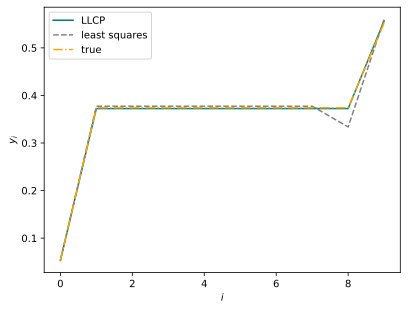

In [71]:
fig = plt.figure()
i = 1
plt.plot(val_preds[i], label='LLCP', color='teal')
plt.plot(lstsq_val_preds[i], label='least squares', linestyle='--', color='gray')
plt.plot(val_outputs[i], label='true', linestyle='-.', color='orange')
w, h = 8, 3.5
plt.xlabel(r'$i$')
plt.ylabel(r'$y_i$')
plt.legend()
plt.show()

# Machine Learning


## Ridge Regression


Ridge regression is a regression technique that is quite similar to unadorned least squares linear regression: simply adding an $\ell_2$ **penalty** on the parameters $\beta$ to the objective function for linear regression yields the objective function for ridge regression.

Our goal is to find an assignment to $\beta$ that minimizes the function

$$f(\beta) = \|X\beta - Y\|_2^2 + \lambda \|\beta\|_2^2,$$

where $\lambda$ is a hyperparameter and, as usual, $X$ is the training data and $Y$ the observations. In practice, we tune $\lambda$ until we find a model that generalizes well to the test data.

Ridge regression is an example of a **shrinkage method**: compared to least squares, it shrinks the parameter estimates in the hopes of **reducing variance, improving prediction accuracy, and aiding interpetation**.

In this notebook, we show how to fit a ridge regression model using CVXPY, how to evaluate the model, and how to tune the hyper-parameter $\lambda$.


In [72]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

### Writing the objective function

We can decompose the **objective function** as the sum of a **least squares loss function** and an $\ell_2$ **regularizer**.


In [73]:
def loss_fn(X, Y, beta):
    return cp.pnorm(cp.matmul(X, beta) - Y, p=2)**2

def regularizer(beta):
    return cp.pnorm(beta, p=2)**2

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value


### Generating data
Because ridge regression encourages the parameter estimates to be small, and as such tends to lead to models with **less variance** than those fit with vanilla linear regression. We generate a small dataset that will illustrate this.


In [74]:
def generate_data(m=100, n=20, sigma=5):
    "Generates data matrix X and observations Y."
    np.random.seed(1)
    beta_star = np.random.randn(n)
    # Generate an ill-conditioned data matrix
    X = np.random.randn(m, n)
    # Corrupt the observations with additive Gaussian noise
    Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
    return X, Y

m = 100
n = 20
sigma = 5

X, Y = generate_data(m, n, sigma)
X_train = X[:50, :]
Y_train = Y[:50]
X_test = X[50:, :]
Y_test = Y[50:]


### Fitting the model



All we need to do to fit the model is create a CVXPY problem where the objective is to minimize the the objective function defined above. We make $\lambda$ a CVXPY parameter, so that we can use a single CVXPY problem to obtain estimates for many values of $\lambda$.


In [75]:
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(X_train, Y_train, beta, lambd)))

lambd_values = np.logspace(-2, 3, 50)
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve(solver=cp.ECOS)
    train_errors.append(mse(X_train, Y_train, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

/root/data/miniconda/envs/cvx/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



### Evaluating the model



Notice that, up to a point, penalizing the size of the parameters reduces test error at the cost of increasing the training error, trading off higher bias for lower variance; in other words, this indicates that, for our example, a properly tuned ridge regression **generalizes better** than a least squares linear regression.


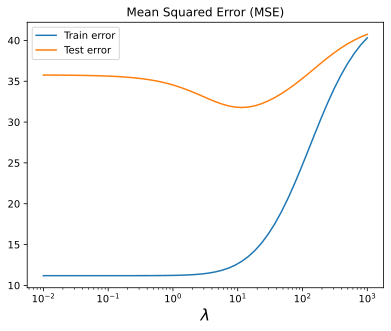

In [76]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()
    
plot_train_test_errors(train_errors, test_errors, lambd_values)


### Regularization path
As expected, increasing $\lambda$ drives the parameters towards $0$. In a real-world example, those parameters that approach zero slower than others might correspond to the more **informative** features. It is in this sense that ridge regression can be considered **model selection.**


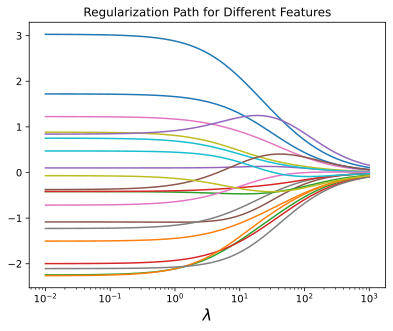

In [77]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path for Different Features")
    plt.show()
    
plot_regularization_path(lambd_values, beta_values)

## Support vector machine classifier with $\ell_1$-regularization


In this example we use CVXPY to train a SVM classifier with $\ell_1$-regularization.
We are given data $(x_i,y_i)$, $i=1,\ldots, m$. The $x_i \in {\bf R}^n$ are feature vectors, while the $y_i \in \{\pm 1\}$ are associated boolean outcomes.
Our goal is to construct a good linear classifier $\hat y = {\rm sign}(\beta^T x - v)$.
We find the parameters $\beta,v$ by minimizing the (convex) function

$$
f(\beta,v) = (1/m) \sum_i \left(1 - y_i ( \beta^T x_i-v) \right)_+ + \lambda
\| \beta\|_1
$$

The first term is the average hinge loss. The second term shrinks the coefficients in $\beta$ and encourages sparsity.
The scalar $\lambda \geq 0$ is a (regularization) parameter.
Minimizing $f(\beta,v)$  simultaneously selects features and fits the classifier.



In the following code we generate data with $n=20$ features by randomly choosing $x_i$ and a sparse $\beta_{\mathrm{true}} \in {\bf R}^n$.
We then set $y_i = {\rm sign}(\beta_{\mathrm{true}}^T x_i -v_{\mathrm{true}} - z_i)$, where the $z_i$ are i.i.d. normal random variables.
We divide the data into training and test sets with $m=1000$ examples each.


In [78]:
# Generate data for SVM classifier with L1 regularization.
# from __future__ import division
import numpy as np
np.random.seed(1)
n = 20
m = 1000
TEST = m
DENSITY = 0.2
beta_true = np.random.randn(n,1)
idxs = np.random.choice(range(n), int((1-DENSITY)*n), replace=False)
for idx in idxs:
    beta_true[idx] = 0
offset = 0
sigma = 45
X = np.random.normal(0, 5, size=(m,n))
Y = np.sign(X.dot(beta_true) + offset + np.random.normal(0,sigma,size=(m,1)))
X_test = np.random.normal(0, 5, size=(TEST,n))
Y_test = np.sign(X_test.dot(beta_true) + offset + np.random.normal(0,sigma,size=(TEST,1)))


We next formulate the optimization problem using CVXPY.


In [79]:
# Form SVM with L1 regularization problem.
import cvxpy as cp
beta = cp.Variable((n,1))
v = cp.Variable()
loss = cp.sum(cp.pos(1 - cp.multiply(Y, X@beta - v)))
reg = cp.norm(beta, 1)
lambd = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(loss/m + lambd*reg))


We solve the optimization problem for a range of $\lambda$ to compute a trade-off curve.
We then plot the train and test error over the trade-off curve.
A reasonable choice of $\lambda$ is the value that minimizes the test error.


In [80]:
# Compute a trade-off curve and record train and test error.
TRIALS = 100
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-2, 0, TRIALS)
beta_vals = []
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve(solver=cp.ECOS)
    train_error[i] = (np.sign(X.dot(beta_true) + offset) != np.sign(X.dot(beta.value) - v.value)).sum()/m
    test_error[i] = (np.sign(X_test.dot(beta_true) + offset) != np.sign(X_test.dot(beta.value) - v.value)).sum()/TEST
    beta_vals.append(beta.value)

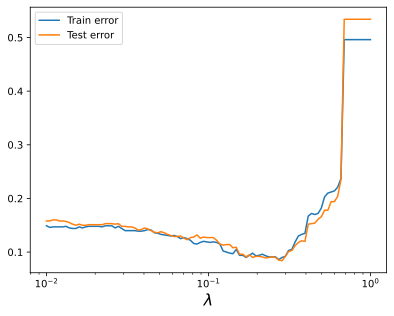

In [81]:
# Plot the train and test error over the trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()


We also plot the regularization path, or the $\beta_i$ versus $\lambda$. Notice that the $\beta_i$ do not necessarily decrease monotonically as $\lambda$ increases.
4 features remain non-zero longer for larger $\lambda$ than the rest, which suggests that these features are the most important. In fact $\beta_{\mathrm{true}}$ had 4 non-zero values.


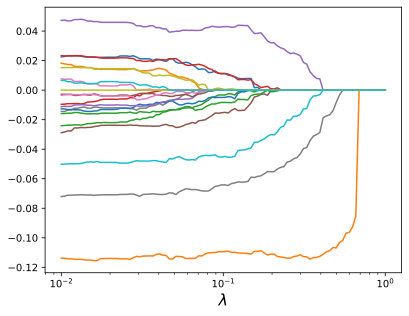

In [82]:
# Plot the regularization path for beta.
for i in range(n):
    plt.plot(lambda_vals, [wi[i,0] for wi in beta_vals])
plt.xlabel(r"$\lambda$", fontsize=16)
plt.xscale("log")

# Advanced

## Method of multipliers


The method of multipliers is an algorithm for solving convex optimization problems. 
Suppose we have a problem of the form

\begin{array}{ll}
\hbox{minimize} & f(x)\\
\hbox{subject to} & Ax = b,
\end{array}

where $f$ is convex, $x \in \mathbf{R}^n$ is the optimization variable, and $A \in \mathbf{R}^{m \times n}$ and $b \in \mathbf{R}^m$ are problem data.

To apply the method of multipliers, we first form the augmented Lagrangian 

$$L_{\rho}(x,y) = f(x) + y^T(Ax - b) + (\rho/2)\|Ax-b\|^2_2.$$

The dual function associated with the augmented Lagrangian is $g_{\rho}(y) = \inf_x L_{\rho}(x,y)$. 
The dual function $g_{\rho}(y)$ is concave and its maximal value is the same as the optimal value of the original problem.

We maximize the dual function using gradient ascent. Each step of gradient ascent reduces to the $x$ and $y$ updates

\begin{array}{lll}
x^{k+1} & := & \mathop{\rm argmin}_{x}\left(f(x) + (y^k)^T(Ax - b) + (\rho/2)\left\|Ax-b\right\|^2_2 \right) \\
y^{k+1} & := & y^{k} + \rho(Ax^{k+1}-b)
\end{array}

The following CVXPY script implements the method of multipliers and uses it to solve an optimization problem.


In [83]:
import cvxpy as cp # type: ignore
import numpy as np
np.random.seed(1)

# Initialize data.
MAX_ITERS = 10
rho = 1.0
n = 20
m = 10
A = np.random.randn(m,n)
b = np.random.randn(m)

# Initialize problem.
x = cp.Variable(shape=n)
f = cp.norm(x, 1)

# Solve with CVXPY.
cp.Problem(cp.Minimize(f), [A@x == b]).solve(cp.ECOS)
print("Optimal value from CVXPY: {}".format(f.value))

# Solve with method of multipliers.
resid = A@x - b
y = cp.Parameter(shape=(m)); y.value = np.zeros(m)
aug_lagr = f + y.T@resid + (rho/2)*cp.sum_squares(resid)
for t in range(MAX_ITERS):
    cp.Problem(cp.Minimize(aug_lagr)).solve(solver=cp.ECOS)
    y.value += rho*resid.value
    
print("Optimal value from method of multipliers: {}".format(f.value))

Optimal value from CVXPY: 5.5731122449706385
Optimal value from method of multipliers: 5.5727615504214665


## $\ell_1$ trend filtering

A derivative work by Judson Wilson, 5/28/2014.<br>
Adapted from the CVX example of the same name, by Kwangmoo Koh, 12/10/2007

Topic Reference:

* S.-J. Kim, K. Koh, S. Boyd, and D. Gorinevsky, ``l_1 Trend Filtering''<br>
http://stanford.edu/~boyd/papers/l1_trend_filter.html


### Introduction

The problem of estimating underlying trends in time series data arises in a variety of disciplines. The $\ell_1$ trend filtering method produces trend estimates $x$ that are piecewise linear from the time series $y$.

The $\ell_1$ trend estimation problem can be formulated as
$$
    \begin{array}{ll}
    \hbox{minimize}   &  (1/2)||y-x||_2^2 + \lambda ||Dx||_1,
    \end{array}
$$
with variable $x$ , and problem data $y$ and $\lambda$, with $\lambda >0$.
$D$ is the second difference matrix, with rows 
    $$\begin{bmatrix}0 & \cdots & 0 & -1 & 2 & -1 & 0 & \cdots & 0 \end{bmatrix}.$$
CVXPY is not optimized for the $\ell_1$ trend filtering problem.
For large problems, use l1_tf (http://www.stanford.edu/~boyd/l1_tf/).


In [84]:
## Formulate and solve problem

import numpy as np
import cvxpy as cp
import scipy as scipy
import cvxopt as cvxopt

# Load time series data: S&P 500 price log.
y = np.loadtxt(open('data/snp500.txt', 'rb'), delimiter=",", skiprows=1)
n = y.size

# Form second difference matrix.
e = np.ones((1, n))
D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)

# Set regularization parameter.
vlambda = 50

# Solve l1 trend filtering problem.
x = cp.Variable(shape=n)
obj = cp.Minimize(0.5 * cp.sum_squares(y - x)
                  + vlambda * cp.norm(D@x, 1) )
prob = cp.Problem(obj)

# ECOS and SCS solvers fail to converge before
# the iteration limit. Use CVXOPT instead.
prob.solve(solver=cp.CVXOPT, verbose=True)
print('Solver status: {}'.format(prob.status))

# Check for error.
if prob.status != cp.OPTIMAL:
    raise Exception("Solver did not converge!")

print("optimal objective value: {}".format(obj.value))


                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 17 11:54:39 AM: Your problem has 1999 variables, 0 constraints, and 0 parameters.
(CVXPY) Nov 17 11:54:39 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 17 11:54:39 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 17 11:54:39 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 17 11:54:39 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 17 11:54:39 AM: Compiling problem (target solver=CVXOPT).


Text(0, 0.5, 'log price')

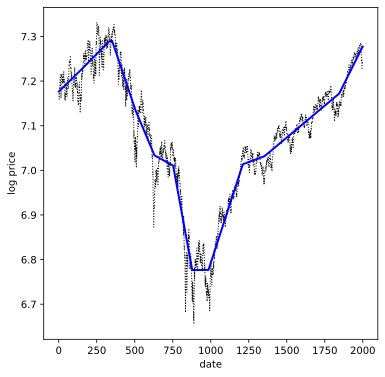

In [85]:
## Results plot
import matplotlib.pyplot as plt

# Show plots inline in ipython.
%matplotlib inline

# Plot properties.
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# font = {'weight' : 'normal',
#         'size'   : 16}
# plt.rc('font', **font)

# Plot estimated trend with original signal.
plt.figure(figsize=(6, 6))
plt.plot(np.arange(1,n+1), y, 'k:', linewidth=1.0)
plt.plot(np.arange(1,n+1), np.array(x.value), 'b-', linewidth=2.0)
plt.xlabel('date')
plt.ylabel('log price')